# Tutorial Python 3 Notebook for Downloading ECCO Datasets from PO.DAAC

**Version 1.1**, 2021-06-25

_Jack McNelis and Ian Fenty_

This notebook provides instructions for downloading a set of granules (files) from an example ECCO "Dataset" hosted by PO.DAAC.

The example ECCO Dataset is "ECCO Sea Surface Height - Daily Mean 0.5 Degree (Version 4 Release 4)" which provides daily sea surface height on the 0.5 degree lat-lon grid ([10.5067/ECG5D-SSH44](https://doi.org/10.5067/ECG5D-SSH44)). 

<img src="https://podaac.jpl.nasa.gov/Podaac/thumbnails/ECCO_L4_SSH_05DEG_DAILY_V4R4.jpg" width="75%" />

More information about this dataset may be found on the [PO.DAAC Web Portal](https://podaac.jpl.nasa.gov). 


## Getting Started

### Python Library Requirements

Most of these imports are from the Python standard library. However, you will need to install these packages into your Python 3 environment if you have not already done so:

* requests
* pandas
* xarray
* tqdm

### Earthdata Login Requirements

An account with NASA Earthdata is required. Please visit [https://urs.earthdata.nasa.gov/home](https://urs.earthdata.nasa.gov/home) to make an account and be ready with your EOSDIS login and password.

*The Earthdata Login provides a single mechanism for user registration and profile management for all EOSDIS system components (DAACs, Tools, Services). Your Earthdata login also helps the EOSDIS program better understand the usage of EOSDIS services to improve user experience through customization of tools and improvement of services. EOSDIS data are openly available to all and free of charge except where governed by international agreements.*

> **Note!**  _some Earthdata password characters may cause problems depending on your system_. To be safe, do not use any of the following characters in your password: backslash (\\), space, hash (#), quotes (single or double), or greater than (>).  Set/change your Earthdata password here: [https://urs.earthdata.nasa.gov/change_password](https://urs.earthdata.nasa.gov/change_password)

1. After creating a NASA Earthdata account, create a file called ```.netrc``` in your home directory (linux, Mac):
```
/home/<username>/.netrc
```
or ```_netrc``` (Windows):
```
C:\Users\<username>\_netrc
```

The ```netrc``` file must have the following structure and must include your Earthdata account login name and password:

```
machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

2. Set permissions on your ```netrc``` file to be readable only by the current user.  If not, you will receive the error "netrc access too permissive." 

```shell
$ chmod 0600 ~/.netrc
```

## Initalize Python libraries

In [1]:
import numpy as np
import pandas as pd
import requests
import shutil
import time as time

# to read and plot the downloaded NetCDF files
import xarray as xr

# for concurrent simulatenous downloads
from concurrent.futures import ThreadPoolExecutor
from getpass import getpass
from http.cookiejar import CookieJar
from io import StringIO
from itertools import repeat
from pathlib import Path
from platform import system
from netrc import netrc
from os.path import expanduser, basename, isfile, isdir, join
# progress bar
from tqdm import tqdm
# library to download files
from urllib import request

# Predict the path of the netrc file depending on os/platform type.
_netrc = join(expanduser('~'), "_netrc" if system()=="Windows" else ".netrc")

## Define Helper Subroutines

### Helper subroutine to log into NASA EarthData 

In [2]:
# not pretty but it works
def setup_earthdata_login_auth(url: str='urs.earthdata.nasa.gov'):
    # look for the netrc file and use the login/password
    try:
        username, _, password = netrc(file=_netrc).authenticators(url)

    # if the file is not found, prompt the user for the login/password
    except (FileNotFoundError, TypeError):
        print('Please provide Earthdata Login credentials for access.')
        username, password = input('Username: '), getpass('Password: ')
    
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, url, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

### Helper subroutines to make the API calls to search CMR and parse response

In [3]:
def set_params(params: dict):
    params.update({'scroll': "true", 'page_size': 2000})
    return {par: val for par, val in params.items() if val is not None}

def get_results(params: dict, headers: dict=None):
    response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.csv", 
                            params=set_params(params),
                            headers=headers)
    return response, response.headers


def get_granules(params: dict):
    response, headers = get_results(params=params)
    scroll = headers['CMR-Scroll-Id']
    hits = int(headers['CMR-Hits'])
    if hits==0:
        raise Exception("No granules matched your input parameters.")
    df = pd.read_csv(StringIO(response.text)) 
    while hits > df.index.size:
        response, _ = get_results(params=params, headers={'CMR-Scroll-Id': scroll})
        data = pd.read_csv(StringIO(response.text))
        df = pd.concat([df, data])
    return df

### Helper subroutine to gracefully download single files and avoids re-downloading if file already exists.  

In [4]:
# To force redownload of the file, pass **True** to the boolean argument *force* (default **False**)
def download_file(url: str, output_dir: str, force: bool=False):
    """
    url (str): the HTTPS url from which the file will download
    output_dir (str): the local path into which the file will download
    force (bool): download even if the file exists locally already
    """
    if not isdir(output_dir):
        raise Exception(f"Output directory doesnt exist! ({output_dir})")
    
    target_file = join(output_dir, basename(url))
    
    # if the file has already been downloaded, skip    
    if isfile(target_file) and force is False:
        print(f'\n{basename(url)} already exists, and force=False, not re-downloading')
        return 0
    
    with requests.get(url) as r:
        if not r.status_code // 100 == 2: 
            raise Exception(r.text)
            return 0
        else:
            with open(target_file, 'wb') as f:
                total_size_in_bytes= int(r.headers.get('content-length', 0))
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)

                return total_size_in_bytes

### Helper subroutine to download all urls in the list `dls`

In [5]:
def download_files_concurrently(dls, download_dir, force=False):
    start_time = time.time()

    # use 3 threads for concurrent downloads
    with ThreadPoolExecutor(max_workers=max_workers) as executor:

        # tqdm makes a cool progress bar
        results = list(tqdm(executor.map(download_file, dls, repeat(download_dir), repeat(force)), total=len(dls)))
    
        # add up the total downloaded file sizes
        total_download_size_in_bytes = np.sum(np.array(results))
        # calculate total time spent in the download
        total_time = time.time() - start_time

        print('\n=====================================')
        print(f'total downloaded: {np.round(total_download_size_in_bytes/1e6,2)} Mb')
        print(f'avg download speed: {np.round(total_download_size_in_bytes/1e6/total_time,2)} Mb/s')

## Download granules of an ECCO dataset falling within a specific date range

## Define dataset parameters

Specify ECCO dataset `ShortName`.  URLs associated with the granules to download using this `ShortName`.

Specify a desired date range using `StartDate` and `EndDate`.  

Here we look for files matching a 7-day range (inclusive), January 1, 2000 to January 7, 2000.  Note, the granule associated with the daily-mean of December 31, 1999 matches the search because its `EndDate` is January 1, 2000.

In [6]:
# ECCO dataset shortname (from PODAAC)
ShortName = "ECCO_L4_SSH_05DEG_DAILY_V4R4"

# desired date range
StartDate = "2000-01-01"
EndDate   = "2000-01-07"

## Define download directory

**Change the `download_root_dir` for your system!**

In [7]:
# define root directory for downloaded NetCDF files
download_root_dir = Path('/Users/ifenty/Downloads/ECCO_V4r4_PODAAC')

# define the 'download_root_dir' where the files will be saved as download_root_dir/ShortName
download_dir = download_root_dir / ShortName

# create the download directory
download_dir.mkdir(exist_ok = True, parents=True)

print(f'created new download directory {download_dir}')

created new download directory /Users/ifenty/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_SSH_05DEG_DAILY_V4R4


## Log into Earthdata using your username and password

In [8]:
# actually log in with this command:
setup_earthdata_login_auth()

## Search NASA's "Common Metadata Repository" for the ECCO dataset

Query the NASA Common Metadata Repository to find the URL of every granule associated with the desired ECCO Dataset and date range of interest.

In [9]:
# create a Python dictionary with our search criteria:  `ShortName` and `temporal`
input_search_params = {'ShortName': ShortName,
                       'temporal': ",".join([StartDate, EndDate])}

print(input_search_params)

{'ShortName': 'ECCO_L4_SSH_05DEG_DAILY_V4R4', 'temporal': '2000-01-01,2000-01-07'}


### Query CMR for the desired ECCO Dataset

Call `get_granules` with the `input_search_params` dictionary argument. The result is a Pandas dataframe with granule metadata results in table form.

In [10]:
# grans means 'granules', PO.DAAC's term for individual files in a dataset
grans = get_granules(input_search_params)

# what did we find? --- 8 granules!
grans.info()

num_grans = len( grans['Granule UR'] )
print (f'\nTotal number of matching granules: {num_grans}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Granule UR           8 non-null      object 
 1   Producer Granule ID  0 non-null      float64
 2   Start Time           8 non-null      object 
 3   End Time             8 non-null      object 
 4   Online Access URLs   8 non-null      object 
 5   Browse URLs          0 non-null      float64
 6   Cloud Cover          0 non-null      float64
 7   Day/Night            8 non-null      object 
 8   Size                 8 non-null      float64
dtypes: float64(4), object(5)
memory usage: 704.0+ bytes

Total number of matching granules: 8


## Download the granules

In [11]:
# convert the rows of the 'Online Access URLS' column to a Python list
dls = grans['Online Access URLs'].tolist()

# the url of the first file is
print(dls[0])

https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4/SEA_SURFACE_HEIGHT_day_mean_1999-12-31_ECCO_V4r4_latlon_0p50deg.nc


### Method 1: Concurrent downloads

Define the maximum number of concurrent downloads (benefits typically taper off above 5-6)

In [12]:
max_workers = 6

Execute the download command

In [13]:
# Ex 1) Force redownload if the file exists
force=True
download_files_concurrently(dls, download_dir, force)

100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


total downloaded: 8.26 Mb
avg download speed: 0.76 Mb/s


In [14]:
# Ex 2) Do not force redownload if the file exists
force=False
download_files_concurrently(dls, download_dir, force)

100%|██████████| 8/8 [00:00<00:00, 11941.08it/s]


SEA_SURFACE_HEIGHT_day_mean_1999-12-31_ECCO_V4r4_latlon_0p50deg.nc already exists, and force=False, not re-downloading
SEA_SURFACE_HEIGHT_day_mean_2000-01-01_ECCO_V4r4_latlon_0p50deg.nc already exists, and force=False, not re-downloading


SEA_SURFACE_HEIGHT_day_mean_2000-01-02_ECCO_V4r4_latlon_0p50deg.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-03_ECCO_V4r4_latlon_0p50deg.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-04_ECCO_V4r4_latlon_0p50deg.nc already exists, and force=False, not re-downloading
SEA_SURFACE_HEIGHT_day_mean_2000-01-06_ECCO_V4r4_latlon_0p50deg.nc already exists, and force=False, not re-downloading
SEA_SURFACE_HEIGHT_day_mean_2000-01-05_ECCO_V4r4_latlon_0p50deg.nc already exists, and force=False, not re-downloading



SEA_SURFACE_HEIGHT_day_mean_2000-01-07_ECCO_V4r4_latlon_0p50deg.nc already exists, and force=False, not re-downloading

total downloaded: 0.0 Mb
avg download s

### Method 2: Sequential Downloads

Download each URL sequentially in a for loop.

In [15]:
total_download_size_in_bytes = 0
start_time = time.time()

# force file download for demonstration purposes
force = True

# loop through all urls in dls
for u in dls:
    u_name = u.split('/')[-1]
    print(f'downloading {u_name}')
    total_download_size_in_bytes += download_file(url=u, output_dir=download_dir, force=force)

# calculate total time spent in the download
total_time = time.time() - start_time

print('\n=====================================')
print(f'total downloaded: {np.round(total_download_size_in_bytes/1e6,2)} Mb')
print(f'avg download speed: {np.round(total_download_size_in_bytes/1e6/total_time,2)} Mb/s')

downloading SEA_SURFACE_HEIGHT_day_mean_1999-12-31_ECCO_V4r4_latlon_0p50deg.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-01_ECCO_V4r4_latlon_0p50deg.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-02_ECCO_V4r4_latlon_0p50deg.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-03_ECCO_V4r4_latlon_0p50deg.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-04_ECCO_V4r4_latlon_0p50deg.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-05_ECCO_V4r4_latlon_0p50deg.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-06_ECCO_V4r4_latlon_0p50deg.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-07_ECCO_V4r4_latlon_0p50deg.nc

total downloaded: 8.26 Mb
avg download speed: 0.29 Mb/s


## Check downloads

Get the list of files:

In [16]:
ecco_netcdf_files = list(download_dir.glob('*nc'))

print(f'number of downloaded files {len(ecco_netcdf_files)}')

number of downloaded files 8


## Plot results

Now open and combine all NetCDF files together using the `xarray.open_mfdataset` function:

In [17]:
xds = xr.open_mfdataset(ecco_netcdf_files, parallel=True, data_vars='minimal',\
                                  coords='minimal', compat='override')

print(xds)

<xarray.Dataset>
Dimensions:         (latitude: 360, longitude: 720, nv: 2, time: 8)
Coordinates:
    latitude_bnds   (latitude, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.75 -179.25 ... 179.25 179.75
  * time            (time) datetime64[ns] 1999-12-31T12:00:00 ... 2000-01-07T...
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    ac

In [18]:
# compute the time mean over the single year
time_mean_SSH = xds.SSH.mean('time').compute()

/Users/ifenty/opt/anaconda3/envs/ecco/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


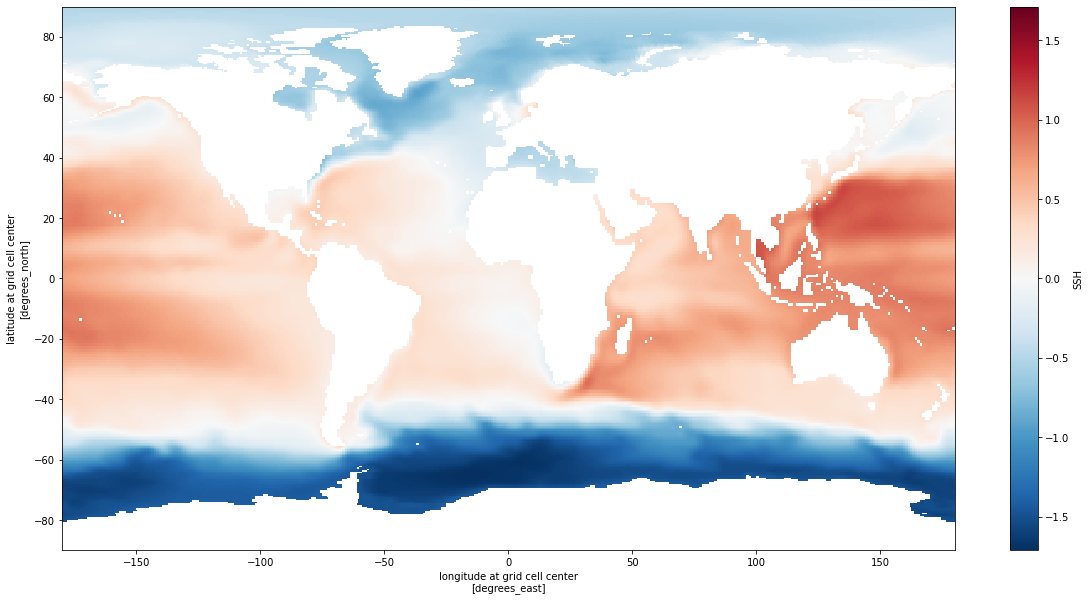

In [19]:
time_mean_SSH.plot(figsize=[20,10])

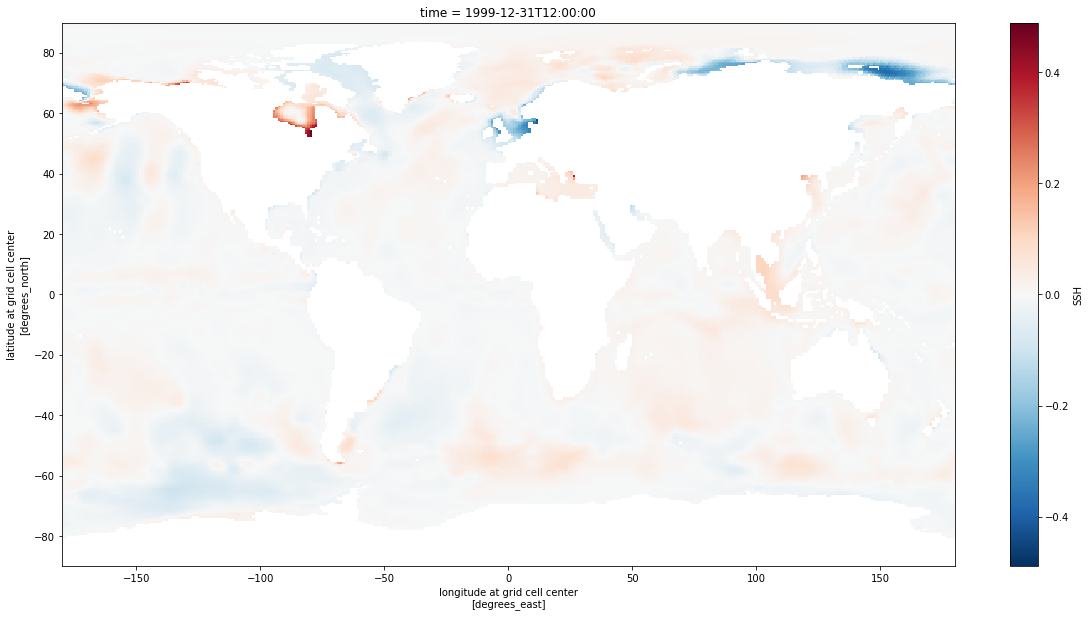

In [20]:
# Plot the anomaly of the first record relative to the time mean
(xds.SSH.isel(time=0) - time_mean_SSH).plot(figsize=[20,10])